In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Jan  8 18:18:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/Cattle_Identification"

from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir)
os.chdir(notebook_dir)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [5]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, embedding_size=128):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc_embedding = nn.Linear(512 * block.expansion, embedding_size)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x_embedding = self.fc_embedding(x)

        return x_embedding, 0

In [7]:
def Resnet34(embedding_size=128):
    return ResNet(BasicBlock, [3, 4, 6, 3], embedding_size=embedding_size)

In [8]:
def Resnet50(embedding_size=128):
    return ResNet(Bottleneck, [3, 4, 6, 3], embedding_size=embedding_size)

In [9]:
def Resnet101(embedding_size=128):
    return ResNet(Bottleneck, [3, 4, 23, 3], embedding_size=embedding_size)

In [10]:
import torch
import torch.nn as nn

class PatchEmbeddings(nn.Module):
    """
      Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3):
        super(PatchEmbeddings, self).__init__()
        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,out_channels=patch_size*patch_size*in_channels,kernel_size=patch_size,stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, patch_size*patch_size*in_channels))
        self.position_embeddings = nn.Parameter(torch.zeros(1, (img_size//patch_size)**2 + 1, patch_size*patch_size*in_channels))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x): # x:(batch_size,3,224,224)
        B = x.shape[0] #B:batch size
        cls_tokens = self.cls_token.expand(B, -1, -1) #cls_token:(1,1,768) -> cls_tokens:(batch_size,1,768)
        # [B, C, H, W] -> [B, C, H*W] ->[B, H*W, C]
        x = self.patch_embeddings(x) # x:(batch_size,768,14,14)
        x = torch.flatten(x,start_dim=2, end_dim=3) # x:(batch_size,768,196)
        x = x.transpose(-1, -2) # x:(batch_size,196,768)
        x = torch.cat((cls_tokens, x), dim=1) # x:(batch_size,197,768)
        embeddings = x + self.position_embeddings # position_embeddings:(1,197,768)
        embeddings = self.dropout(embeddings)
        return embeddings

In [11]:
import math
class Multi_Head_Attention(nn.Module):
    def __init__(self,att_heads_num=12, img_size=224, patch_size=16, in_channels=3):
        super(Multi_Head_Attention, self).__init__()
        self.att_heads_num = att_heads_num
        self.att_head_size = int(patch_size*patch_size*in_channels / self.att_heads_num)  # 64
        self.all_head_size = self.att_heads_num * self.att_head_size #768

        self.query = nn.Linear(patch_size*patch_size*in_channels, self.all_head_size)
        self.key = nn.Linear(patch_size*patch_size*in_channels, self.all_head_size)
        self.value = nn.Linear(patch_size*patch_size*in_channels, self.all_head_size)

        self.out = nn.Linear(patch_size*patch_size*in_channels, patch_size*patch_size*in_channels)
        self.attn_dropout = nn.Dropout(0.0)
        self.proj_dropout = nn.Dropout(0.0)

        self.softmax = nn.Softmax(dim=-1)

    def transpose_for_scores(self, x): # (batch_size,197,768)
        new_x_shape = \
            x.size()[:-1] + (self.att_heads_num, self.att_head_size)
        x = x.view(new_x_shape) # (batch_size,197,12,64)
        return x.permute(0, 2, 1, 3)  # (batch_size,12,197,64)

    def forward(self, hidden_states): # (batch_size,197,768)
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer) # (batch_size,12,197,64)
        key_layer = self.transpose_for_scores(mixed_key_layer) # (batch_size,12,197,64)
        value_layer = self.transpose_for_scores(mixed_value_layer) # (batch_size,12,197,64)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.att_head_size)
        attention_probs = self.softmax(attention_scores)

        weights =  None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() # (batch_size,197,12,64)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)

        return attention_output, weights

In [12]:
ACT2FN = {"gelu": torch.nn.functional.gelu,
          "relu": torch.nn.functional.relu}

class Mlp(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3):
        super(Mlp, self).__init__()
        self.fc1 = nn.Linear(patch_size*patch_size*in_channels, 4*patch_size*patch_size*in_channels)
        self.fc2 = nn.Linear(4*patch_size*patch_size*in_channels, patch_size*patch_size*in_channels)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [13]:
class Block(nn.Module):
    def __init__(self, att_heads_num=12, img_size=224, patch_size=16, in_channels=3):
        super(Block, self).__init__()
        self.attention_norm = nn.LayerNorm(patch_size*patch_size*in_channels, eps=1e-6)
        self.multi_head_attn = Multi_Head_Attention(att_heads_num=att_heads_num, img_size=img_size, patch_size=patch_size, in_channels=in_channels)
        self.ffn_norm = nn.LayerNorm(patch_size*patch_size*in_channels, eps=1e-6)
        self.ffn = Mlp(img_size=img_size, patch_size=patch_size, in_channels=in_channels)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.multi_head_attn(x)
        x = x + h
        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

In [14]:
import copy
class Encoder(nn.Module):
    def __init__(self, num_blocks=12, att_heads_num=12, img_size=224, patch_size=16, in_channels=3):
        super(Encoder, self).__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(patch_size*patch_size*in_channels, eps=1e-6)
        for _ in range(num_blocks):
            layer = Block(att_heads_num=att_heads_num, img_size=img_size, patch_size=patch_size, in_channels=in_channels)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, embedding_output):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(embedding_output)

        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

In [15]:
class ViT(nn.Module):
    def __init__(self, num_blocks=12, att_heads_num=12, img_size=224, patch_size=16, in_channels=3):
        super(ViT, self).__init__()
        self.patchEmbeddings = PatchEmbeddings(img_size=img_size, patch_size=patch_size, in_channels=in_channels)
        self.encoder = Encoder(num_blocks=num_blocks, att_heads_num=att_heads_num, img_size=img_size, patch_size=patch_size, in_channels=in_channels)

    def forward(self, input_ids):
        embedding_output = self.patchEmbeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

In [16]:
class ViTNet(nn.Module):
    def __init__(self, num_blocks=12, att_heads_num=12, img_size=224, patch_size=16, in_channels=3, embedding_size=128):
        super(ViTNet, self).__init__()
        self.transformer = ViT(num_blocks=num_blocks, att_heads_num=att_heads_num, img_size=img_size, patch_size=patch_size, in_channels=in_channels)
        self.fc_embedding = nn.Linear(patch_size*patch_size*in_channels, embedding_size)

    def forward(self, x): # x:(batch_size,3,224,224)
        x, attn_weights = self.transformer(x) # (batch_size,197,768)
        x_embedding = self.fc_embedding(x[:, 0])
        return x_embedding, attn_weights

In [17]:
import numpy as np
from torch.utils.data.sampler import BatchSampler

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [18]:
from itertools import combinations
class RandomTripletSelector():
    """
    Select random negative example for each positive pair to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [19]:
import torch.nn.functional as F
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [20]:
import matplotlib.pyplot as plt
from tqdm import tqdm
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 test_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.test_DataLoader = test_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

      train_loss = []
      test_loss = []

      for epoch in tqdm(range(self.epochs)):
          self.model.train()  # train mode

          train_losses=[]
          for batch in self.training_DataLoader:

              x,y=batch
              input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
              self.optimizer.zero_grad()  # zerograd the parameters
              out, _ = self.model(input)  # one forward pass
              loss = self.criterion(out, target)  # calculate loss

              loss_value = loss.item()
              train_losses.append(loss_value)

              loss.backward()  # one backward pass
              self.optimizer.step()  # update the parameters



          self.model.eval()  # evaluation mode
          test_losses = []  # accumulate the losses here

          for batch in self.test_DataLoader:

              x,y=batch
              input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

              with torch.no_grad():
                  out, _ = self.model(input)   # one forward pass
                  loss = self.criterion(out, target) # calculate loss

                  loss_value = loss.item()
                  test_losses.append(loss_value)

          mean_train_loss = np.mean(train_losses)
          mean_test_loss = np.mean(test_losses)
          train_loss.append(mean_train_loss)
          test_loss.append(mean_test_loss)

          # print the results
          print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',end=' ')
          print(f'TRAIN-LOSS: {mean_train_loss:.4f}',end=' ')
          print(f'TEST-LOSS: {mean_test_loss:.4f}',end='\n')

      plt.figure(figsize=(8,6))
      plt.title('Loss curve')
      plt.plot(range(self.epochs), train_loss, label="train_loss")
      plt.plot(range(self.epochs), test_loss, label="test_loss")
      plt.legend()
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.show

In [21]:
def query_generator(images, labels, n_queries, n_candidates):
  import numpy as np
  import random
  labels = labels.cpu().data.numpy()
  queries = []
  for label in set(labels):
    label_mask = (labels == label)
    label_indices = np.where(label_mask)[0]
    if len(label_indices) < 2:
        continue
    negative_indices = np.where(np.logical_not(label_mask))[0]
    anchor_positives = list(combinations(label_indices, 2))
    for anchor_positive in anchor_positives:
      anchor = anchor_positive[0]
      positive = anchor_positive[1]
      negatives = np.random.choice(negative_indices, size=n_candidates-1, replace=False)
      truth = np.random.randint(n_candidates)
      candidates = np.insert(negatives, truth, positive)
      queries.append([anchor, candidates, truth])
  sampled_queries = random.sample(queries, n_queries)
  anchor_images, candidates_images, truth = [],[],[]
  for sampled_query in sampled_queries:
    anchor_images.append(images[sampled_query[0]])
    temp_candidate_images = []
    for index in sampled_query[1]:
      temp_candidate_images.append(images[index])
    tensor_candidate_images = torch.stack(temp_candidate_images, 0)
    candidates_images.append(tensor_candidate_images)
    truth.append(sampled_query[2])
  return torch.stack(anchor_images, 0), torch.stack(candidates_images, 0), truth

In [22]:
# function to determine performance of model
def query_performance(model, queries, targets, truth, top=1):
  from scipy.spatial.distance import cdist
  assert top >= 1
  cnt = 0
  for i in range(len(truth)):
      q = queries[i][None].float().cuda()
      t = targets[i].float().cuda()

      with torch.no_grad():

          emb_q = model(q)[0].cpu().numpy()
          emb_t = model(t)[0].cpu().numpy()

          dists = cdist(emb_q, emb_t)

          if top == 1:
              pred = np.argmin(dists)

              if pred == truth[i]:
                  cnt += 1

          else:
              pred = np.argsort(dists)
              if truth[i] in pred[0,:top].tolist():
                  cnt+=1
  return (cnt/len(truth))

In [23]:
def eval_performance(model, images, labels, n_queries, n_candidates, iters):
  tops = list(range(1,n_candidates))
  acc = np.zeros(n_candidates - 1)
  for _ in range(iters):
    queries_tensor, targets_tensor, truth = query_generator(images, labels, n_queries, n_candidates)
    for top in tops:
      acc[top-1] += query_performance(model, queries_tensor, targets_tensor, truth, top)
  results = np.divide(acc, iters)
  for top in tops:
    print(f'top{top} acc: {results[top-1]:.4f}',end='\n')

In [24]:
def feature_label_split(npz):
  import numpy as np
  import torch
  X_array = npz['images']
  y_array = npz['labels']
  state = np.random.get_state()
  np.random.shuffle(X_array)
  np.random.set_state(state)
  np.random.shuffle(y_array)
  return torch.tensor(np.transpose(X_array, (0,3,1,2))).float(), torch.tensor(y_array).float()

In [25]:
X_train, y_train = feature_label_split(np.load(notebook_dir + '/datasets/10-90/resize/train.npz'))
X_test, y_test = feature_label_split(np.load(notebook_dir + '/datasets/10-90/resize/test.npz'))
X_eval, y_eval = feature_label_split(np.load(notebook_dir + '/datasets/10-90/resize/eval.npz'))
print(f"Image train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Image test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")
print(f"Image eval shape: {X_eval.shape}")
print(f"Label eval shape: {y_eval.shape}")

Image train shape: torch.Size([71, 3, 224, 224])
Label train shape: torch.Size([71])
Image test shape: torch.Size([18, 3, 224, 224])
Label test shape: torch.Size([18])
Image eval shape: torch.Size([919, 3, 224, 224])
Label eval shape: torch.Size([919])


In [26]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

  2%|▏         | 1/50 [00:00<00:13,  3.73it/s]

EPOCH: 01/50 TRAIN-LOSS: 2.0009 TEST-LOSS: 3.7978


  4%|▍         | 2/50 [00:00<00:11,  4.02it/s]

EPOCH: 02/50 TRAIN-LOSS: 0.5207 TEST-LOSS: 0.2684


  6%|▌         | 3/50 [00:00<00:11,  4.12it/s]

EPOCH: 03/50 TRAIN-LOSS: 1.4921 TEST-LOSS: 0.3247


  8%|▊         | 4/50 [00:00<00:11,  4.02it/s]

EPOCH: 04/50 TRAIN-LOSS: 0.2926 TEST-LOSS: 0.1337


 10%|█         | 5/50 [00:01<00:11,  4.04it/s]

EPOCH: 05/50 TRAIN-LOSS: 0.6581 TEST-LOSS: 0.3082


 12%|█▏        | 6/50 [00:01<00:10,  4.09it/s]

EPOCH: 06/50 TRAIN-LOSS: 0.6842 TEST-LOSS: 0.3149


 14%|█▍        | 7/50 [00:01<00:10,  4.13it/s]

EPOCH: 07/50 TRAIN-LOSS: 0.7042 TEST-LOSS: 0.1629


 16%|█▌        | 8/50 [00:01<00:10,  4.16it/s]

EPOCH: 08/50 TRAIN-LOSS: 0.5225 TEST-LOSS: 0.2211


 18%|█▊        | 9/50 [00:02<00:09,  4.16it/s]

EPOCH: 09/50 TRAIN-LOSS: 0.2694 TEST-LOSS: 0.3116


 20%|██        | 10/50 [00:02<00:09,  4.07it/s]

EPOCH: 10/50 TRAIN-LOSS: 0.3681 TEST-LOSS: 0.0931


 22%|██▏       | 11/50 [00:02<00:09,  4.10it/s]

EPOCH: 11/50 TRAIN-LOSS: 0.2386 TEST-LOSS: 0.9935


 24%|██▍       | 12/50 [00:02<00:09,  4.16it/s]

EPOCH: 12/50 TRAIN-LOSS: 0.1676 TEST-LOSS: 0.4688


 26%|██▌       | 13/50 [00:03<00:08,  4.16it/s]

EPOCH: 13/50 TRAIN-LOSS: 0.3338 TEST-LOSS: 0.8644


 28%|██▊       | 14/50 [00:03<00:08,  4.11it/s]

EPOCH: 14/50 TRAIN-LOSS: 0.2253 TEST-LOSS: 0.0954


 30%|███       | 15/50 [00:03<00:08,  4.13it/s]

EPOCH: 15/50 TRAIN-LOSS: 0.8200 TEST-LOSS: 0.4022


 32%|███▏      | 16/50 [00:03<00:08,  4.19it/s]

EPOCH: 16/50 TRAIN-LOSS: 0.5153 TEST-LOSS: 0.6367


 34%|███▍      | 17/50 [00:04<00:07,  4.23it/s]

EPOCH: 17/50 TRAIN-LOSS: 0.1899 TEST-LOSS: 1.3881


 36%|███▌      | 18/50 [00:04<00:07,  4.18it/s]

EPOCH: 18/50 TRAIN-LOSS: 0.7469 TEST-LOSS: 0.2291


 38%|███▊      | 19/50 [00:04<00:07,  4.17it/s]

EPOCH: 19/50 TRAIN-LOSS: 0.3109 TEST-LOSS: 0.1775


 40%|████      | 20/50 [00:04<00:07,  4.20it/s]

EPOCH: 20/50 TRAIN-LOSS: 0.4104 TEST-LOSS: 0.0227


 42%|████▏     | 21/50 [00:05<00:06,  4.23it/s]

EPOCH: 21/50 TRAIN-LOSS: 0.5250 TEST-LOSS: 0.6652


 44%|████▍     | 22/50 [00:05<00:06,  4.26it/s]

EPOCH: 22/50 TRAIN-LOSS: 0.0962 TEST-LOSS: 0.3358


 46%|████▌     | 23/50 [00:05<00:06,  4.21it/s]

EPOCH: 23/50 TRAIN-LOSS: 0.1811 TEST-LOSS: 0.1175


 48%|████▊     | 24/50 [00:05<00:06,  4.20it/s]

EPOCH: 24/50 TRAIN-LOSS: 0.1724 TEST-LOSS: 0.4213


 50%|█████     | 25/50 [00:06<00:05,  4.21it/s]

EPOCH: 25/50 TRAIN-LOSS: 0.9696 TEST-LOSS: 0.2063


 52%|█████▏    | 26/50 [00:06<00:05,  4.19it/s]

EPOCH: 26/50 TRAIN-LOSS: 0.2842 TEST-LOSS: 0.0000


 54%|█████▍    | 27/50 [00:06<00:05,  4.20it/s]

EPOCH: 27/50 TRAIN-LOSS: 0.1394 TEST-LOSS: 0.0666


 56%|█████▌    | 28/50 [00:06<00:05,  4.23it/s]

EPOCH: 28/50 TRAIN-LOSS: 0.4588 TEST-LOSS: 0.0870


 58%|█████▊    | 29/50 [00:06<00:04,  4.24it/s]

EPOCH: 29/50 TRAIN-LOSS: 0.2429 TEST-LOSS: 0.6748


 60%|██████    | 30/50 [00:07<00:04,  4.21it/s]

EPOCH: 30/50 TRAIN-LOSS: 0.2719 TEST-LOSS: 0.7362


 62%|██████▏   | 31/50 [00:07<00:04,  4.20it/s]

EPOCH: 31/50 TRAIN-LOSS: 0.2293 TEST-LOSS: 0.3067


 64%|██████▍   | 32/50 [00:07<00:04,  4.14it/s]

EPOCH: 32/50 TRAIN-LOSS: 0.2252 TEST-LOSS: 0.0267


 66%|██████▌   | 33/50 [00:07<00:04,  4.11it/s]

EPOCH: 33/50 TRAIN-LOSS: 0.9046 TEST-LOSS: 0.8562


 68%|██████▊   | 34/50 [00:08<00:03,  4.09it/s]

EPOCH: 34/50 TRAIN-LOSS: 0.4344 TEST-LOSS: 0.0000


 70%|███████   | 35/50 [00:08<00:03,  4.13it/s]

EPOCH: 35/50 TRAIN-LOSS: 0.2442 TEST-LOSS: 0.0000


 72%|███████▏  | 36/50 [00:08<00:03,  4.12it/s]

EPOCH: 36/50 TRAIN-LOSS: 0.4220 TEST-LOSS: 0.9669


 74%|███████▍  | 37/50 [00:08<00:03,  4.16it/s]

EPOCH: 37/50 TRAIN-LOSS: 0.2667 TEST-LOSS: 0.1771


 76%|███████▌  | 38/50 [00:09<00:02,  4.18it/s]

EPOCH: 38/50 TRAIN-LOSS: 0.3476 TEST-LOSS: 0.1479


 78%|███████▊  | 39/50 [00:09<00:02,  4.18it/s]

EPOCH: 39/50 TRAIN-LOSS: 0.1147 TEST-LOSS: 0.1238


 80%|████████  | 40/50 [00:09<00:02,  4.13it/s]

EPOCH: 40/50 TRAIN-LOSS: 0.2235 TEST-LOSS: 0.5725


 82%|████████▏ | 41/50 [00:09<00:02,  4.17it/s]

EPOCH: 41/50 TRAIN-LOSS: 0.5939 TEST-LOSS: 0.0000


 84%|████████▍ | 42/50 [00:10<00:01,  4.21it/s]

EPOCH: 42/50 TRAIN-LOSS: 0.1200 TEST-LOSS: 0.0565


 86%|████████▌ | 43/50 [00:10<00:01,  4.21it/s]

EPOCH: 43/50 TRAIN-LOSS: 0.2650 TEST-LOSS: 0.0000


 88%|████████▊ | 44/50 [00:10<00:01,  4.23it/s]

EPOCH: 44/50 TRAIN-LOSS: 0.2457 TEST-LOSS: 0.0408


 90%|█████████ | 45/50 [00:10<00:01,  4.25it/s]

EPOCH: 45/50 TRAIN-LOSS: 0.3832 TEST-LOSS: 0.6135


 92%|█████████▏| 46/50 [00:11<00:00,  4.25it/s]

EPOCH: 46/50 TRAIN-LOSS: 0.4183 TEST-LOSS: 0.0000


 94%|█████████▍| 47/50 [00:11<00:00,  4.22it/s]

EPOCH: 47/50 TRAIN-LOSS: 0.9471 TEST-LOSS: 2.6962


 96%|█████████▌| 48/50 [00:11<00:00,  4.24it/s]

EPOCH: 48/50 TRAIN-LOSS: 0.9994 TEST-LOSS: 3.1608


 98%|█████████▊| 49/50 [00:11<00:00,  4.27it/s]

EPOCH: 49/50 TRAIN-LOSS: 0.2588 TEST-LOSS: 1.2038


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]

EPOCH: 50/50 TRAIN-LOSS: 1.1179 TEST-LOSS: 0.6255


top1 acc: 0.5047
top2 acc: 0.7040
top3 acc: 0.8487
top4 acc: 0.9413


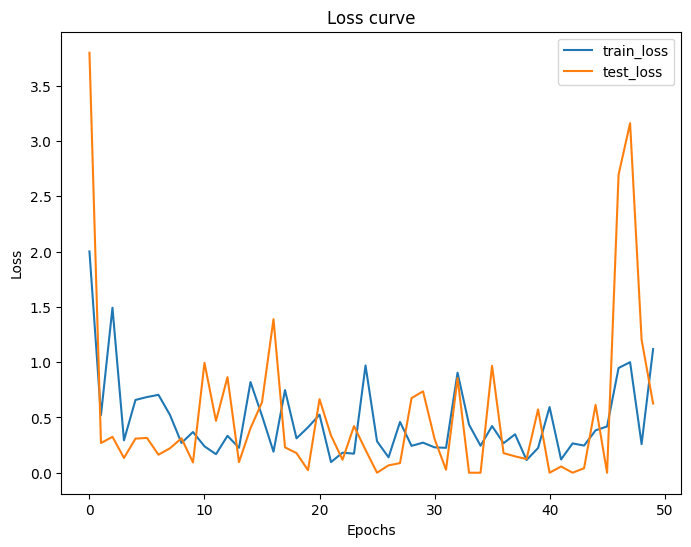

In [35]:
#parameters
learning_rate = 1e-4
epochs = 50
n_classes = 8
n_samples = 2
margin = 0.4
embedding_size = 256

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
# model = ViTNet(embedding_size=embedding_size).to(device)
# model = Resnet34(embedding_size=embedding_size).to(device)
# model = Resnet50(embedding_size=embedding_size).to(device)
model = Resnet101(embedding_size=embedding_size).to(device)

# dataloaders
train_batch_sampler = BalancedBatchSampler(y_train.tolist(), n_classes=n_classes, n_samples=n_samples)
test_batch_sampler = BalancedBatchSampler(y_test.tolist(), n_classes=n_classes, n_samples=n_samples)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)


# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  test_DataLoader=triplets_test_loader,
                  epochs=epochs)

# start training
trainer.run_trainer()

#evaluate model
eval_performance(model, X_eval, y_eval, 50, 5, 30)